# Project 2d object classification projected in 3d space

Uses a cascade classifier to find objects on a 2d image, then project into 3d space. 
In this way, the locations of the objects are identified in the 3d point cloud. 
As input Kinect depth and RGB images were taken, therefore the computations are dependent on the Kinect sensor calibration parameters.

If multiple objects are detected, Non-Maximum-Suppression is applied to get the true positives.

Note: for visualization purposes, the pyvista and itk viewer is used. Please follow the installation instructions: 
https://github.com/InsightSoftwareConsortium/itkwidgets

More details on the implementation, algorithms can be found here:
```
https://github.com/fvilmos/kinect_point_cloud - visualization of Kinect 3d data
https://github.com/fvilmos/cascade_tools - train your cascade
https://github.com/fvilmos/cascade_nms - false positive filtering with Non-Maximum-Suppression
```


In [1]:
from IPython import display
import pyvista as pv
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from utils.pcreg import *
from utils.cascade import *
from utils.nms import *

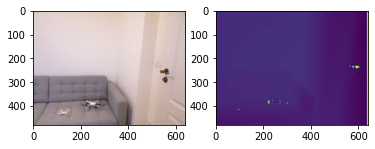

In [2]:
# import depth and rgb data from kinect
depthf = 'data/depth.npy'
rgbf = 'data/rgb.npy'

frame = np.load(rgbf)
depth = np.load(depthf)

# plot the informtion
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(frame)
ax = fig.add_subplot(1, 2, 2)
plt.imshow(depth)


Draw detections on the 2d image and compute 2d bounding box centers. This information will be used lather to find in the 3d Point Cloud the corresponding points

Nr of boxes: 8, coordinates: 
[[222 370  58  41]
 [223 367  64  45]
 [219 369  64  45]
 [110 411  53  37]
 [ 96 401  64  45]
 [ 94 403  64  45]
 [205 362  86  60]
 [ 90 403  71  50]],
Nr of filtered detections: 2, coordinates: 
[array([ 90, 403,  71,  50], dtype=int32), array([205, 362,  86,  60], dtype=int32)]


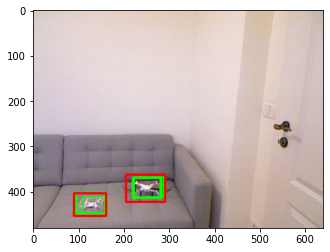

In [3]:
# detect with cascade the target object(s)
img = []
img = frame.copy()
cf = 'data/cascade.xml'

# detect / classify objects on ther frames
cas = Cascade(cf)
cas.set_parameters(neighbor=0)
detections = cas.get_detections(img)

#display detections (unfiltered)
cas.display(img)

print ('Nr of boxes: {}, coordinates: \n{},'.format(len(detections), detections))

nms=NMS()

#filter detections
fdet= nms.non_maximum_surpression(detections,THRESHOLD=0.1)

#display filtered
for val in fdet:
    cv2.rectangle(img,(val[0],val[1]),(val[0]+val[2],val[1]+val[3]),[255,0,0],3)
print ('Nr of filtered detections: {}, coordinates: \n{}'.format(len(fdet),fdet))

plt.imshow(img)

In [4]:
# create a point cloud registration class, used to process kinect depth / rgb images
pcreg = PointCloudRegistration()

# project depth / rgb into 3d 
pc_points, pc_colors = pcreg.get_registred_depth_rgb(depth,frame)

In [5]:
def get_centroid_from_pc(detections,pc,pcreg=None,detector_shape=(640,480)):
    """
    On a given 3d pointclud, projects the 2d Cascade classifications to 3d 
    extracts and provides objects centroids

    Args:
        detections (list): Cascade type object classifications (x,y,w,h)
        pc (Pointcloude): 3d pointclude P[x,y,z]
        pcreg (Point lud object, optional): Holds the Kinect specific rotation/ translations needed to project the points on the correct place in 3d. Defaults to None.
        detector_shape (tuple, optional): Kinect specific sensor information. Defaults to (640,480).

    Returns:
        (list): retunrs 3d centroids for classified objects Cp[x,y,z] and the 2d equvivalents [Cx,Cy,w,h] 
    """

    ret = []
    #resize, transfor to Kinects RGB sensor coordinate
    tpc = pc.reshape(-1,detector_shape[0],3).copy()
    
    tpc = np.dot(tpc, pcreg.RGBCamParams['rot'].T)
    tpc = np.add(tpc, pcreg.RGBCamParams['trans'])

    # do for all objects detected
    for d in detections:
        cx = int(d[0] + d[2]/2)
        cy = int(d[1] + d[3]/2)

        # 3d projected centroids [x,y,z]
        c3d = tpc[cy,cx]
        
        # detection centers, w, h
        c2d = (cx,cy,d[2],d[3])
        
        # 3d centroid coordinates
        ret.append((c3d,c2d))
        
    return ret

In [6]:
ret = get_centroid_from_pc(fdet,pc_points,pcreg)

In [7]:
print (pc_points.shape,pc_colors.shape)

(480, 640, 3) (480, 640, 3)


Draw the detection on the Point Cloud. 
Position is indicated by shperes, dimention is derived from width in 2d space.

In [8]:
# prepare itk plotter
plotter = pv.PlotterITK()
plotter.background_color = [0.1,0.1,0.1]

# detection scaling factor
scale = 0.00125

# draw all detections in 3d space as spheres
for c3d,c2d in ret:
    sphere = pv.Sphere(radius=c2d[2]*scale,center=c3d)
    plotter.add_mesh(sphere, color=[0,1,0],opacity=0.3)

# create Point Cloud
pc = pv.PolyData(pc_points)
plotter.add_mesh(pc,scalars=pc_colors.reshape(-1,3))

In [9]:
plotter.camera_position = [(0.0, -0.2, -1.0), (0.0, 0.0, 0.0), (0.0, 0.0, 1.0)]
out= plotter.show()


Viewer(background=(0.1, 0.1, 0.1), camera=array([[ 0. , -0.2, -1. ],
       [ 0. ,  0. ,  0. ],
       [ 0. , …